In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import pandas as pd
import uproot as ur
import statistics
import k3d
import numpy as np
import awkward as ak
import matplotlib.colors as mcolors
from scipy.stats import norm
import mplhep as hep
import hist
from hist import Hist
from iminuit import Minuit

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["legend.fontsize"] = 16

In [2]:
#random trigger data
ptrigDF = pd.read_pickle(r'Cosmic_Runs_Run6_list.pkl')
#cosmic data
cosmic_df = pd.read_pickle(r'Cosmic_Runs_Run5_list.pkl')

#set to 1 for 4k files, 2 for 8k files
ADCmult = 1

#All hits below this threshold are set to zero
MIPCut = 0.3

#Apply MIP scaling and pedestal ADC value here for simulation

#ADCs per MIP for simulation, set to 1 if the file is in units of MIPs
ADCtoMIP = 1

#Pedestal value for simulation, in whatever units the file is in
SimPedestal = 0

simPedMeans = np.full(40, SimPedestal)
simMips = np.full(40, ADCtoMIP)

In [3]:
print(ptrigDF)

       Ch_00_LG  Ch_00_HG  Ch_01_LG  Ch_01_HG  Ch_02_LG  Ch_02_HG  Ch_03_LG  \
0          44.0      32.0      44.0      25.0      37.0      31.0      39.0   
1          51.0      47.0      39.0      47.0      36.0      31.0      41.0   
2          43.0      36.0      44.0      27.0      42.0      17.0      40.0   
3          47.0      71.0      48.0      78.0      51.0      74.0      48.0   
4          48.0      58.0      47.0      56.0      42.0      52.0      37.0   
...         ...       ...       ...       ...       ...       ...       ...   
10535      45.0      52.0      39.0      34.0      42.0      48.0      42.0   
10536      46.0      71.0      45.0      62.0      49.0      58.0      50.0   
10537      47.0     102.0      43.0     104.0      47.0      93.0      37.0   
10538      45.0      70.0      38.0      70.0      42.0      60.0      38.0   
10539      45.0      59.0      43.0      44.0      40.0      36.0      41.0   

       Ch_03_HG  Ch_04_LG  Ch_04_HG  ...  Ch_18_HG 

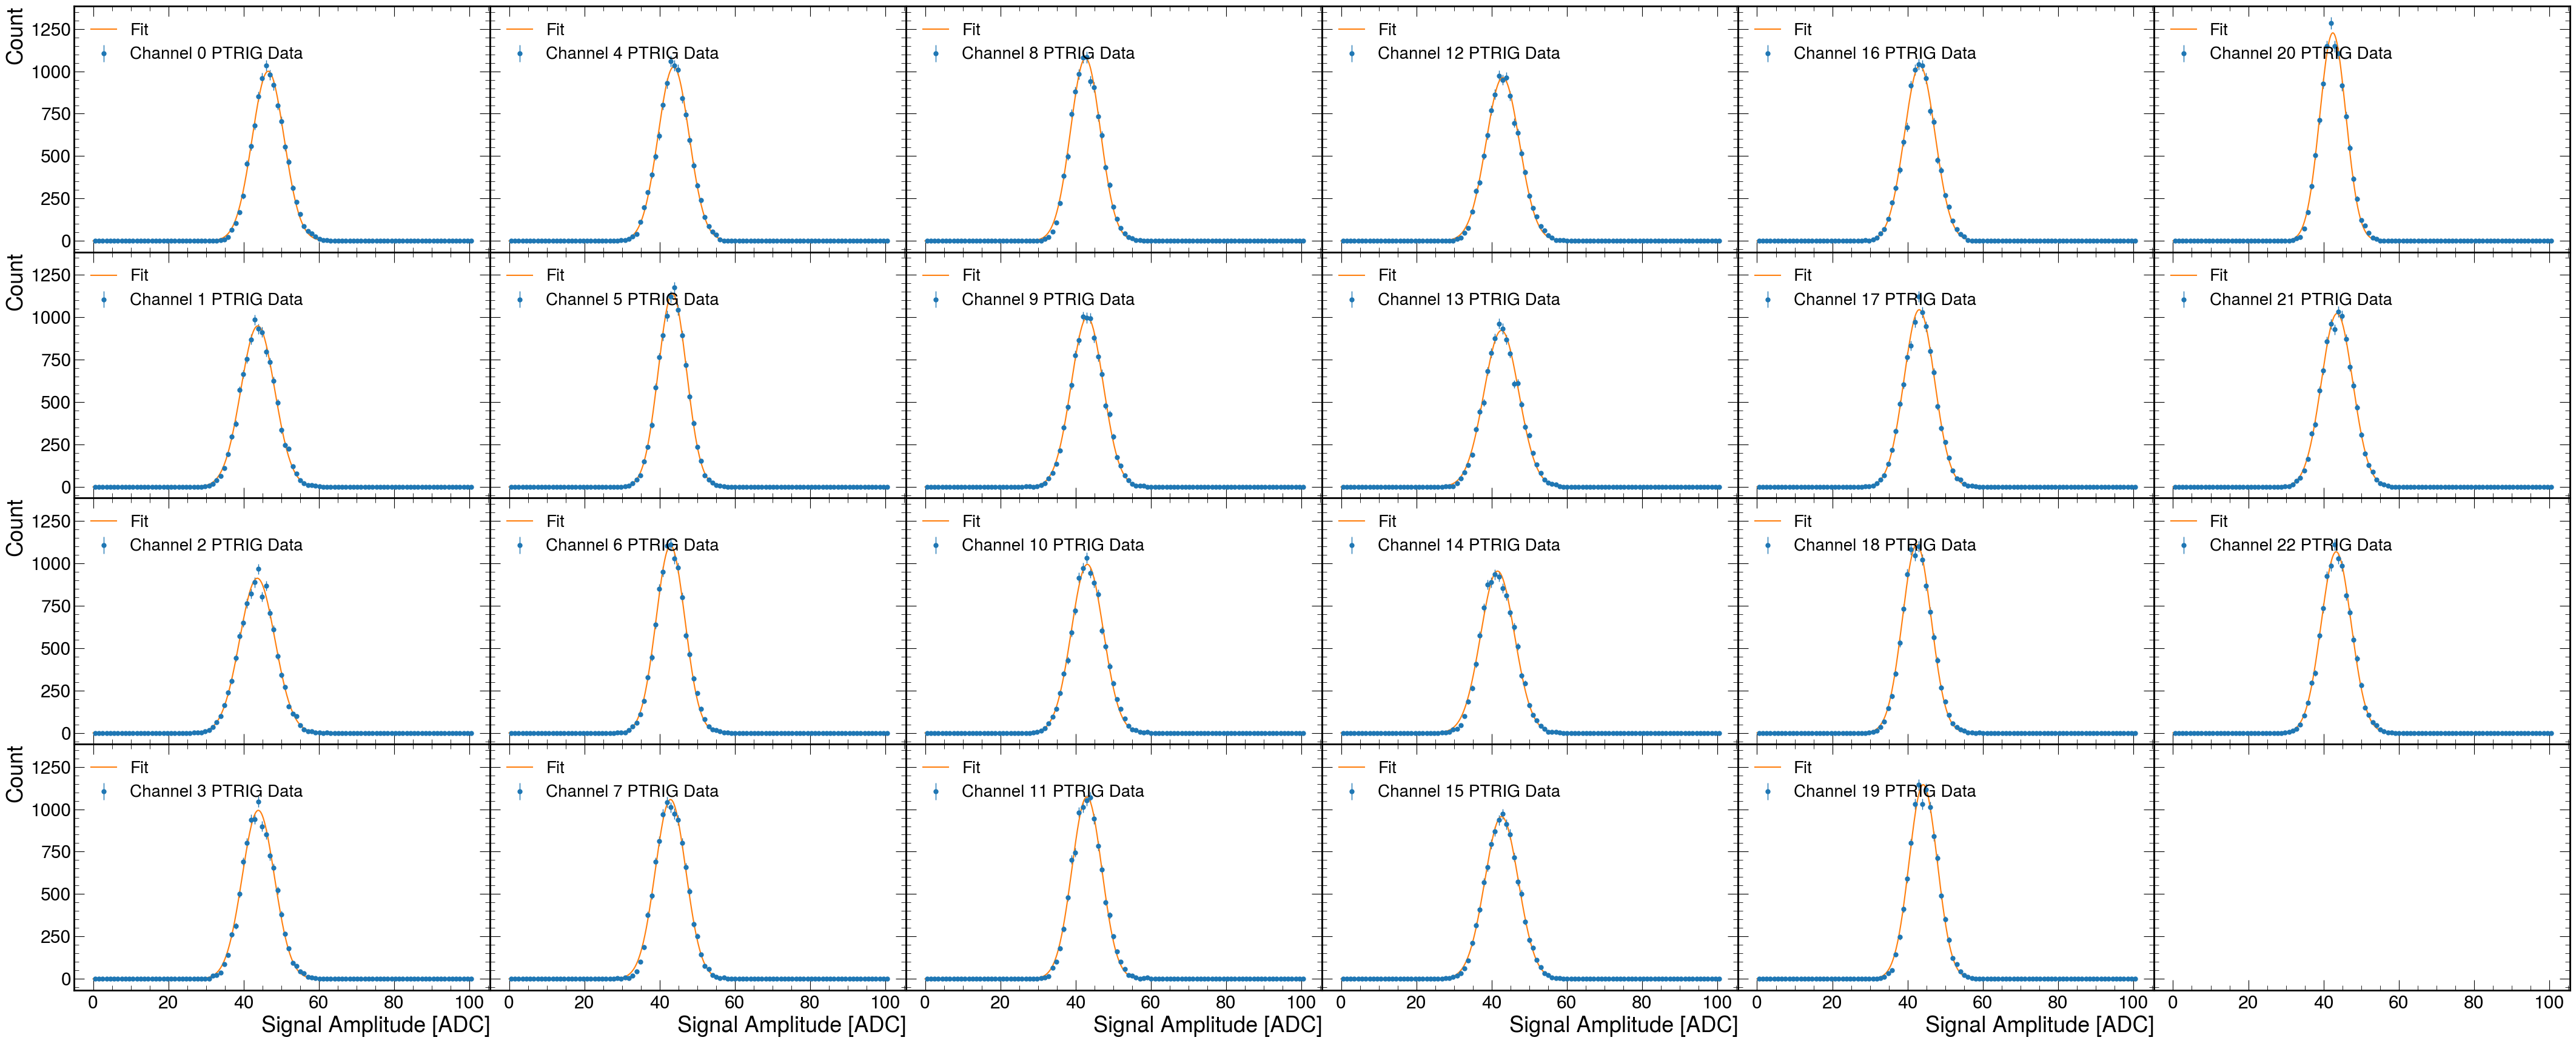

In [4]:
#plot random trigger spectra for each low gain channel. Fit to gaussian and record pedestals for cuts later

fig, axs=plt.subplots(4, 6, figsize=(0.9*len(cosmic_df.columns),17),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

pedMeans = []
pedStds = []

for i in range(23):
    plt.sca(axs[i%4][i//4])
    
    h = hist.Hist(hist.axis.Regular(100, 0, 101, name="Ptrig"))
    h.fill(np.array(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))))
    #h.plot(color='blue',label=f"Channel {i} PTRIG Data")  
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
    bins = bin_centers
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} PTRIG Data")

    # Initial parameter values for the fit
    initial_params = [max(h), sum(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i))))/len(getattr(ptrigDF,"Ch_{}_LG".format("{:02d}".format(i)))), 3.]

    # Create Minuit object and set up the fit
    m = Minuit(least_squares_loss, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    # Set limits for the sigma parameter
    m.limits["sigma"] = (0, None)
    # Perform the fit
    m.migrad()
    # Get the fitted parameters
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    
    x = np.linspace(0, 100, 1000)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, 'tab:orange', label='Fit')

    plt.legend(loc='upper left', fontsize=20)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%4 == 0:
        plt.xlabel('Signal Amplitude [ADC]')
    if i <= 3:
        plt.ylabel('Count')
  
    #plt.yscale("log") 
    
    pedMeans.append(mu_fit)
    pedStds.append(sigma_fit)
    
# Adjust the spacing between subplots
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

Average mean value:
43.247027857205296
Average width value:
4.136708920051153


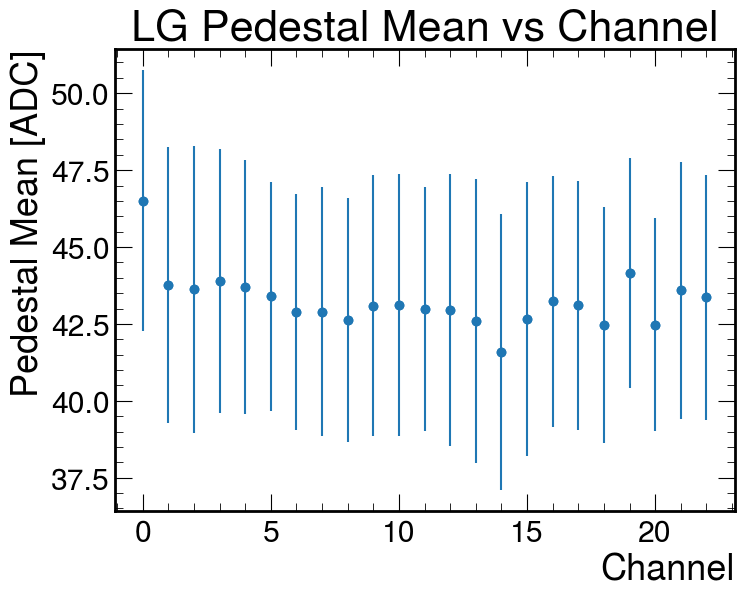

In [5]:
#plot pedestals means and stds for low gain

fig = plt.figure( figsize=(8, 6))
plt.scatter(range(0,23),pedMeans)
plt.xlabel('Channel')
plt.ylabel('Pedestal Mean [ADC]')
plt.title("LG Pedestal Mean vs Channel")
plt.errorbar(range(0,23), pedMeans, yerr=pedStds, fmt="o")
print("Average mean value:")
print(np.mean(pedMeans))
print("Average width value:")
print(np.mean(pedStds))

C:\Users\miama\AppData\Local\Temp\ipykernel_14728\2503574381.py:11: RuntimeWarning: overflow encountered in exp
  return Aprime*np.exp((-u)/2 - np.exp(-u)/2)


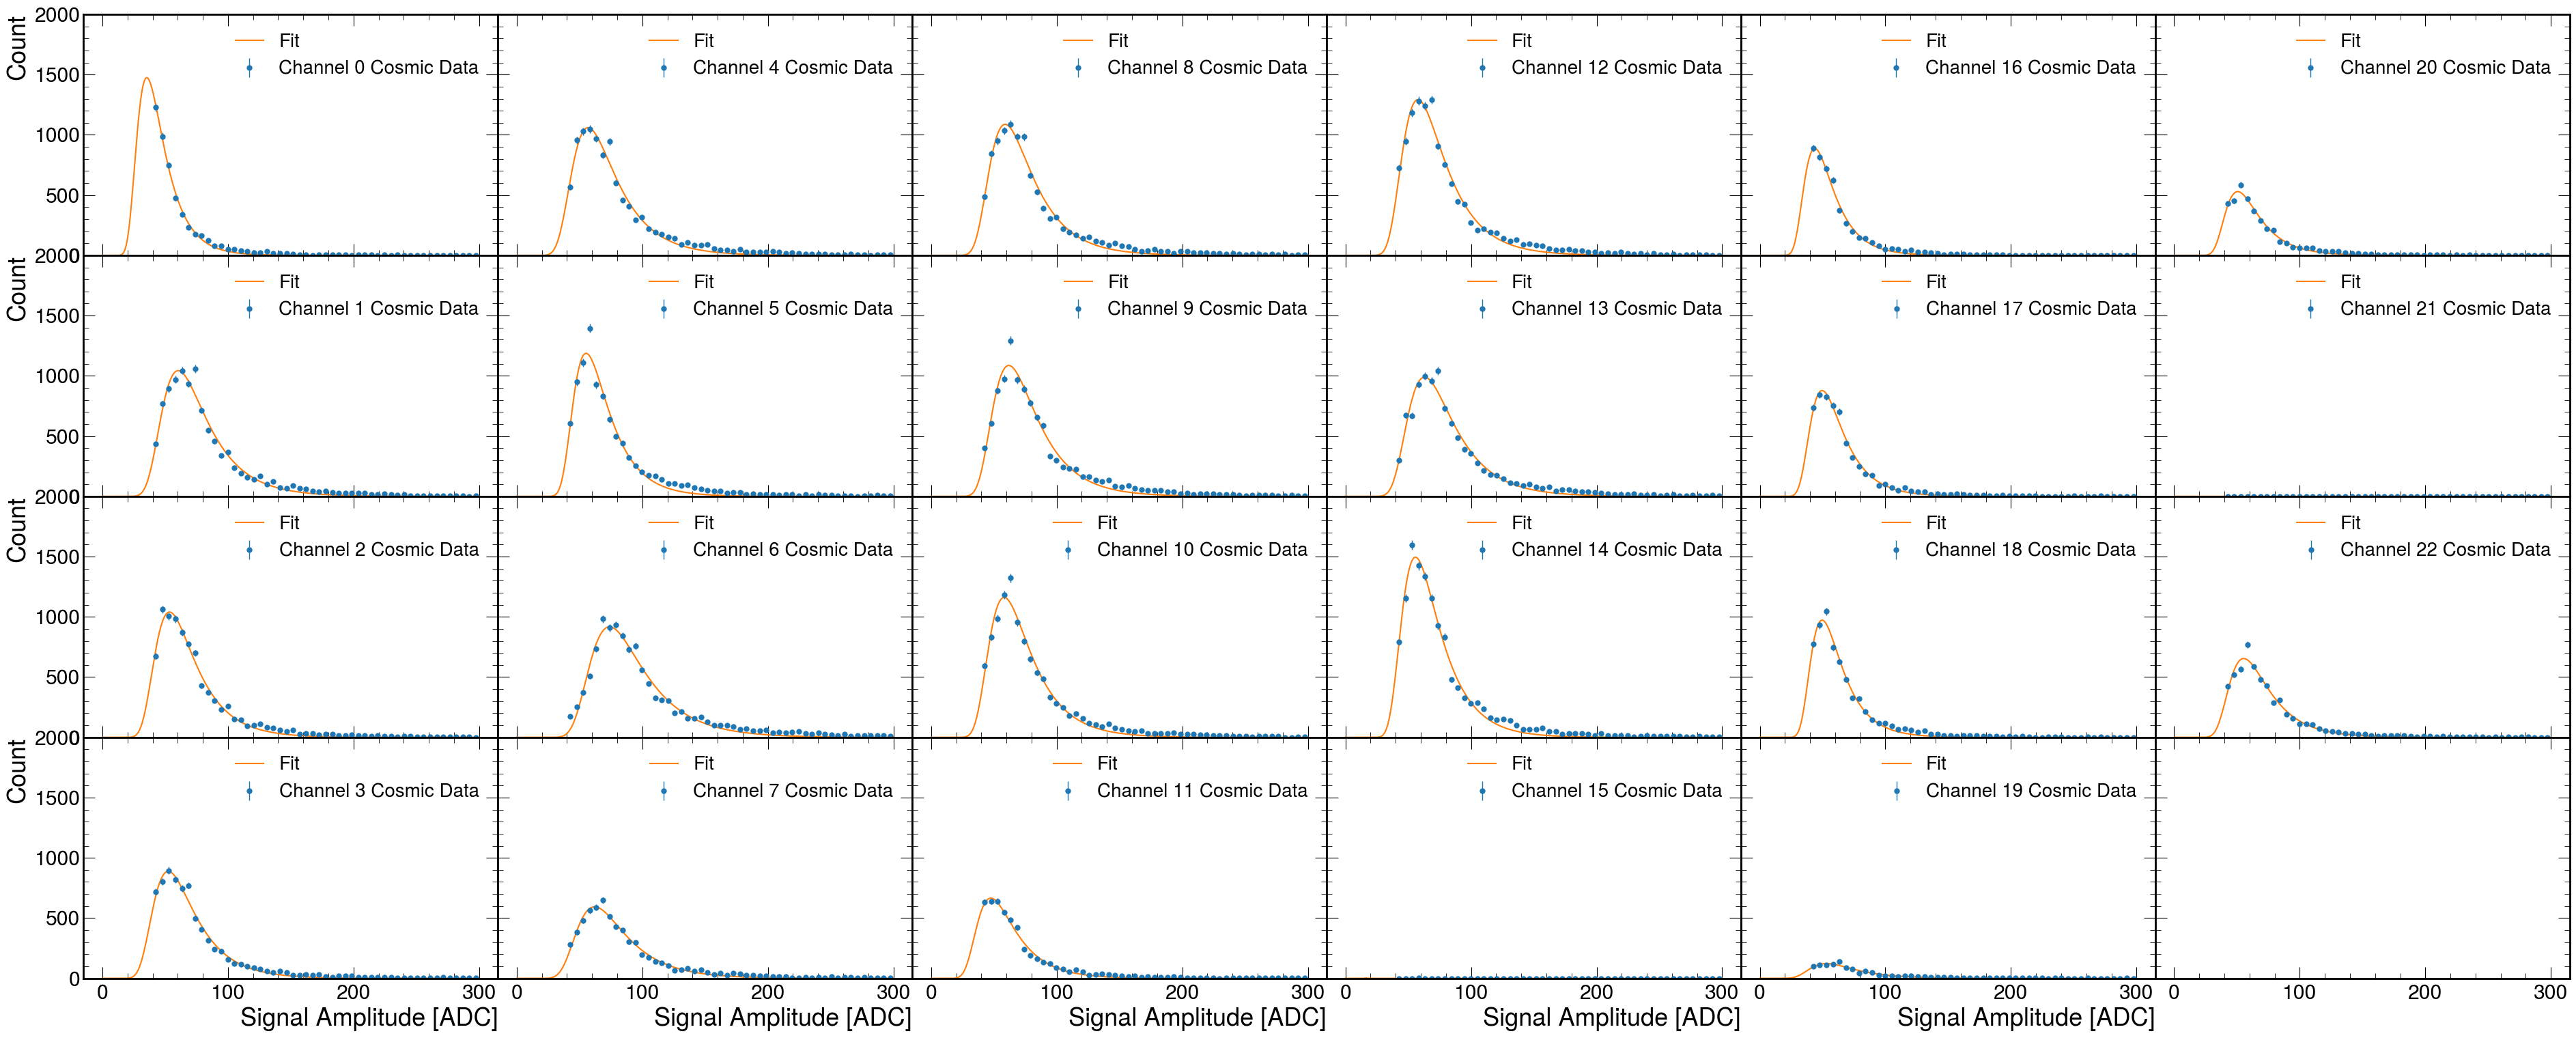

In [6]:
#plot random trigger spectra for each low gain channel. Fit to gaussian and record pedestals for cuts later

fig, axs=plt.subplots(4, 6, figsize=(0.8*len(cosmic_df.columns),15),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def landau(x, A, mu, sigma):
    u = (x - mu)*3.591/(sigma/2.355)
    Aprime = 1.648*A
    return Aprime*np.exp((-u)/2 - np.exp(-u)/2)

def least_squares_landau(A, mu, sigma):
    y = landau(bins, A, mu, sigma)
    return np.sum((data - y)**2)

mips = []
mipStds = []

for i in range(23):
    plt.sca(axs[i%4][i//4])

    h = hist.Hist(hist.axis.Regular(50, 40, 300, name="Ptrig"))
    
    cosmicCh = np.array(getattr(cosmic_df,"Ch_{}_LG".format("{:02d}".format(i))))
    cosmicCh = cosmicCh[cosmicCh >= (pedStds[i] *3)+pedMeans[i]] - pedMeans[i]
  #the logic of the cut is that the cosmic chanel has to be less than or equal to the (ped standard X 4) plus the ped means @index i - pedmeans @index i
   
    h.fill(cosmicCh)
    #h.plot(color='tab:blue',label=f"Channel {i} Cosmic Data")  
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])
    
    data = h.values()[()]
    bins = bin_centers
    
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i} Cosmic Data")

    
    # Find the bin number with the maximum value
    max_bin_number = np.argmax(h.values())

    # Get the axis from the histogram
    axis = h.axes[0]

    # Find the x-coordinate corresponding to the maximum bin
    x_coordinate = axis.edges[max_bin_number]
    #mips.append(x_coordinate)
    
    # Initial parameter values for the fit
    initial_params = [max(h), np.mean(cosmicCh), np.std(cosmicCh)]
    # Create Minuit object and set up the fit
    m = Minuit(least_squares_landau, A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    # Set limits for the sigma parameter
    m.limits["sigma"] = (0, None)
    m.limits["mu"] = (0, 200)
    # Perform the fit
    m.migrad()
    # Get the fitted parameters
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    
    x = np.linspace(0, 300, 1000)
    y_fit = landau(x, A_fit, mu_fit, sigma_fit)
    plt.plot(x, y_fit, 'tab:orange', label='Fit')

    plt.legend(loc='upper right', fontsize=20)    
    
    # Set the title and axis labels for the subplot   
    if (i+1)%4 == 0:
        plt.xlabel('Signal Amplitude [ADC]')
    if i <= 3:
        plt.ylabel('Count')
    
    mips.append(mu_fit)
    mipStds.append(sigma_fit)
    
# Adjust the spacing between subplots
plt.ylim(0,2000)
plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

Average mean value:
51.51900517744861
Average width value:
84.87005609161105


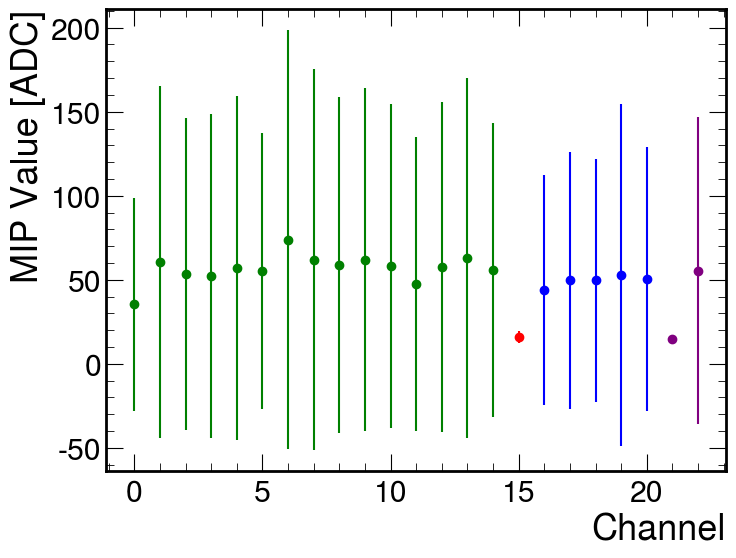

In [7]:
mips = np.array(mips)


fig = plt.figure( figsize=(8, 6))
plt.errorbar(range(0,15), mips[0:15], yerr=mipStds[0:15], fmt="o", color = "green")
plt.errorbar(range(15,16), mips[15:16], yerr=mipStds[15:16], fmt="o", color = "red")
plt.errorbar(range(16,21), mips[16:21], yerr=mipStds[16:21], fmt="o", color = "blue")
plt.errorbar(range(21,23), mips[21:23], yerr=mipStds[21:23], fmt="o", color = "purple")

plt.xlabel('Channel')
plt.ylabel('MIP Value [ADC]')

print("Average mean value:")
print(np.mean(mips))
print("Average width value:")
print(np.mean(mipStds))



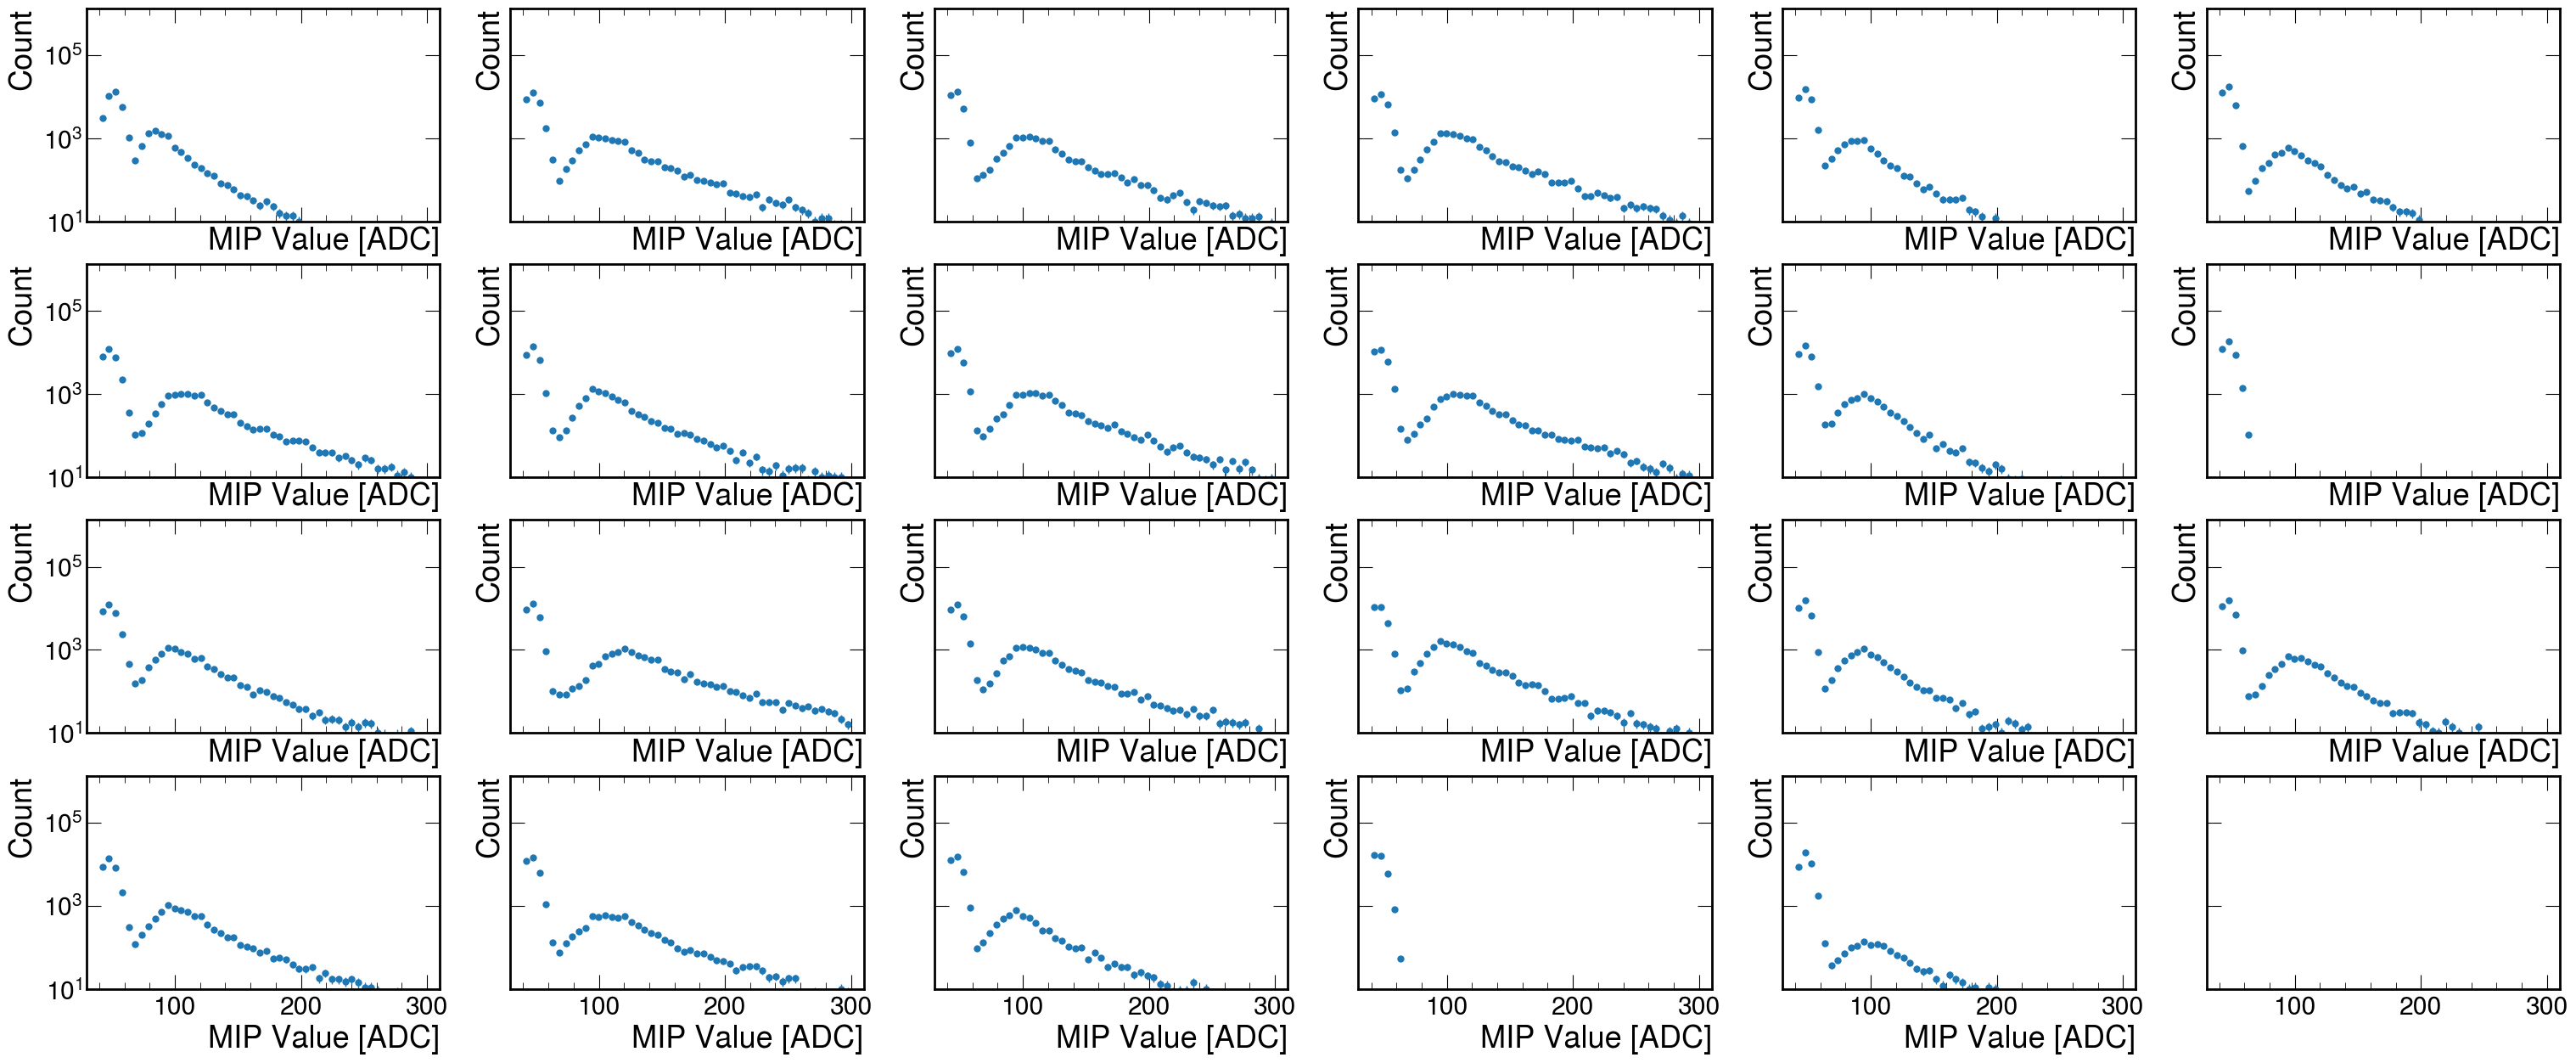

In [8]:
fig, axs=plt.subplots(4, 6, figsize=(0.8*len(cosmic_df.columns),15),sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def landau(x, A, mu, sigma):
    u = (x - mu)*3.591/(sigma/2.355)
    Aprime = 1.648*A
    return Aprime*np.exp((-u)/2 - np.exp(-u)/2)

def least_squares_landau(A, mu, sigma):
    y = landau(bins, A, mu, sigma)
    return np.sum((data - y)**2)

mips = []
mipStds = []

for i in range(23):
    plt.sca(axs[i%4][i//4])

    h = hist.Hist(hist.axis.Regular(50, 40, 300, name="Ptrig"))
    
    cosmicCh = np.array(getattr(cosmic_df,"Ch_{}_LG".format("{:02d}".format(i))))
   
    h.fill(cosmicCh)
    #h.plot(color='tab:blue',label=f"Channel {i} Cosmic Data")  
    # Create a numpy array for the bin centers
    bin_centers = 0.5 * (h.axes[0].edges[:-1] + h.axes[0].edges[1:])

    
    data = h.values()[()]
    bins = bin_centers
    plt.ylim(10,1350000)

    plt.ylabel('Count')
    plt.xlabel('MIP Value [ADC]')
    
    plt.errorbar(bins,data,yerr=np.sqrt(data),fmt='o',ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0,label=f"Channel {i}Cosmic Data")
    plt.yscale("log")